In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. C:\Users\p2admin\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64\tmpds8poa\key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '17244' (I am process '8180')
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpx88yrw/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpx88yrw/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((1000,64*64))
trX=trX
%matplotlib inline
for i in range(1000):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    #temp[temp>=0.5]=1
    #temp[temp<=0.5]=0
    temp=temp.reshape(-1)
    data2[i,:]=np.round(temp/max(temp)*255.)

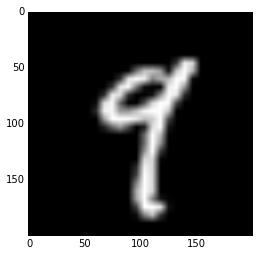

In [79]:
np.set_printoptions(threshold='nan')
plt.imshow(data2[0].reshape(200,200),'gray')
#plt.imshow(trX[0].reshape(28,28),'gray')

In [3]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [4]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
np.set_printoptions(threshold='nan')

In [5]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score

trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#trX=data2
trX = trX[0:1000]
vaX = floatX(vaX[0:1000])/255.

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
ny = 10           # # of classes
nbatch = 100      # # of examples in batch
npx = 28          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain, nval, ntest = len(trX), len(vaX), len(teX)

def transform(X):
    return (floatX(X)/255.).reshape(-1, nc, npx, npx)

def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X



relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
bce = T.nnet.binary_crossentropy

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

# encoder
ew  = difn((ndf, nc, 5, 5), 'ew')
eg = gain_ifn((ndf), 'eg')
eb = bias_ifn((ndf), 'eb')

ew2 = difn((ndf*2, ndf, 5, 5), 'ew2')
eg2 = gain_ifn((ndf*2), 'eg2')
eb2 = bias_ifn((ndf*2), 'eb2')

ew3 = difn((ndf*2*7*7, ndfc), 'ew3')
eg3 = gain_ifn((ndfc), 'eg3')
eb3 = bias_ifn((ndfc), 'eb3')

bmu = bias_ifn((nz), 'bmu')
wmu = difn((ndf*2*7*7, nz), 'wmu')
bsigma = bias_ifn((nz), 'bsigma')
wsigma = difn((ndf*2*7*7, nz), 'wsigma')

# generate
gw  = gifn((nz, ngfc), 'gw')
gg = gain_ifn((ngfc), 'gg')
gb = bias_ifn((ngfc), 'gb')

gw2 = gifn((ngfc, ngf*2*7*7), 'gw2')
gg2 = gain_ifn((ngf*2*7*7), 'gg2')
gb2 = bias_ifn((ngf*2*7*7), 'gb2')

gw3 = gifn((ngf*2, ngf, 5, 5), 'gw3')
gg3 = gain_ifn((ngf), 'gg3')
gb3 = bias_ifn((ngf), 'gb3')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

# discrim
dw  = difn((ndf, nc, 5, 5), 'dw')

dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')

dw3 = difn((ndf*2*7*7, ndfc), 'dw3')
dg3 = gain_ifn((ndfc), 'dg3')
db3 = bias_ifn((ndfc), 'db3')

dwy = difn((ndfc, 1), 'dwy')

enc_params = [ew, eg, eb, ew2, eg2, eb2, wmu, bmu, wsigma, bsigma]
gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gwx]
dis_params = [dw,dw2,dg2,db2, dw3,dg3,db3, dwy]

def enc(X, w, eg1, eb1, w2, eg2, eb2, wmu, bmu, wsigma, bsigma):
    h1 = relu(batchnorm(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)),g=eg1, b=eb1))
    h2 = relu(batchnorm(dnn_conv(h1, w2, subsample=(2, 2), border_mode=(2, 2)),g=eg2, b=eb2))
    h3 = T.flatten(h2, 2)
    z_mu = T.dot(h3, wmu) + bmu
    z_log_sigma = 0.5 * (T.dot(h3, wsigma) + bsigma)
    z = z_mu + T.exp(z_log_sigma) 
    return z_mu, z_log_sigma, z

def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 7, 7))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def dis(X, w, w2, dg2, db2, w3, dg3, db3, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=dg2,b=db2))
    feature = h2
    h3 = T.flatten(h2, 2)
    h4 = lrelu(batchnorm(T.dot(h3, w3), g=dg3,b=db3))
    y = sigmoid(T.dot(h4, wy))
    return y, feature

X = T.tensor4()
Z = T.matrix() 

In [12]:
# Pretraining
gX = gen(Z, *gen_params)

p_real,_ = dis(X, *dis_params)
p_gen,_ = dis(gX, *dis_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(dis_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
#updates = d_updates + g_updates

print 'COMPILING'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
t = time()
for epoch in range(1, niter+niter_decay+1):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    #if (epoch-1) % 5 == 0:
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    #print g_cost, d_cost

 10%|████▎                                      | 1/10 [00:00<00:04,  1.90it/s]


KeyboardInterrupt: 

In [23]:
# Post-training
encZ_mu,encZ_log_sigma,encZ = enc(X, *enc_params)

from keras import backend as K
epsilon = K.random_normal(shape=(nbatch, nz), mean=0.,
                              std=1)
sampling_Z = encZ_mu + T.exp(encZ_log_sigma / 2) * epsilon

X_tilde = gen(sampling_Z, *gen_params)

Z_rand = K.random_normal(shape=(nbatch, nz), mean=0.,std=1)
X_p = gen(Z_rand, *gen_params)

d_real, xl_real = dis(X, *dis_params)
d_gen, xl_gen = dis(X_tilde, *dis_params)
d_p, xl_p = dis(X_p, *dis_params)

enc_loss_kl = -0.5*T.mean(1+encZ_log_sigma-T.square(encZ_mu)-T.exp(encZ_log_sigma),axis=-1)
enc_loss_sim= T.mean(T.sum((xl_gen-xl_real)**2))

# d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
# d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
# g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost_real = bce(d_real, T.zeros(d_real.shape)).mean()
d_cost_gen = bce(d_gen, T.ones(d_gen.shape)).mean()
d_cost_p = bce(d_p, T.ones(d_p.shape)).mean()

GAN_loss = (d_cost_real + d_cost_gen + d_cost_p)
enc_cost = T.mean(enc_loss_kl + enc_loss_sim)
gen_cost = 0.1*enc_loss_sim - GAN_loss # paper version
dis_cost = GAN_loss # paper version


cost = [enc_cost,gen_cost,dis_cost]

lrt = sharedX(lr)
enc_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
gen_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
dis_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))

enc_updates = enc_updater(enc_params, enc_cost)
gen_updates = gen_updater(gen_params, gen_cost)
dis_updates = dis_updater(dis_params, dis_cost)


print 'COMPILING'
t = time()

_train_enc = theano.function([X], enc_cost, updates=enc_updates)
_train_gen = theano.function([X,Z_rand,sampling_Z], gen_cost, updates=gen_updates)
_train_dis = theano.function([X,Z_rand,sampling_Z], dis_cost, updates=dis_updates)
_enc = theano.function([X], [encZ_mu, encZ_log_sigma])
_gen = theano.function([sampling_Z], X_tilde)

print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0

enc_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
for epoch in range(1, 2000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0,1, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost) 

10 5545.4775 431.2307 1.3532
10 4837.6011 377.0342 1.3555
10 4906.0161 380.1336 1.3643
10 5084.2827 403.2338 1.3732
10 5082.6289 368.2819 1.3370
10 5554.1724 393.2324 1.3892
10 6293.6367 468.2263 1.3813
10 4790.7178 377.9853 1.4408
10 5311.2139 432.3339 1.3813
10 5275.5137 399.3458 1.3851
20 5272.7656 411.6309 1.3164
20 5414.9150 384.4130 1.3341
20 5320.8325 404.9501 1.3899
20 5215.6157 388.8960 1.3176
20 5033.1079 382.0526 1.3422
20 4832.9712 389.0077 1.4157
20 4958.9136 384.1314 1.3304
20 4921.2168 362.8128 1.3789
20 4995.7017 381.9384 1.3703
20 4864.9238 377.4435 1.3301
30 4473.5059 332.6849 1.5184
30 4654.1982 349.7186 1.4105
30 4365.4487 317.4416 1.4115
30 4679.8149 355.4612 1.5006
30 4526.5200 311.4094 1.3780
30 4773.1914 326.0540 1.3859
30 4738.8286 340.7428 1.4567
30 4183.0654 316.6696 1.4502
30 4851.9814 366.1495 1.4261
30 5227.2822 362.8963 1.4068
40 4683.2202 332.2354 1.3971
40 5444.2583 361.8330 1.3921
40 5559.5288 353.5982 1.3817
40 4165.0762 310.5249 1.4076
40 5022.6792 3

KeyboardInterrupt: 

In [61]:
lrt.set_value(floatX(0.000000002))
for epoch in range(20000, 200000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0,1, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost)  

20000 24.1203 0.3151 0.9760
20000 23.5939 0.2074 1.0302
20000 22.2831 0.0039 1.1367
20000 22.6345 0.0528 1.1110
20000 22.1579 0.0233 1.1131
20000 91.7121 7.9833 0.0998
20000 36.0507 1.4768 1.0536
20000 50.1874 3.7636 0.1428
20000 22.6178 0.1430 1.0358
20000 22.8377 0.0637 1.0908
20010 24.0670 0.3161 0.9751
20010 23.5851 0.2082 1.0295
20010 22.2992 0.0020 1.1356
20010 22.6230 0.0507 1.1078
20010 22.1825 0.0225 1.1111
20010 91.7188 7.9859 0.1010
20010 36.0347 1.4772 1.0522
20010 50.1958 3.7669 0.1411
20010 22.6562 0.1396 1.0353
20010 22.7954 0.0623 1.0946
20020 24.1277 0.3127 0.9751
20020 23.6289 0.2102 1.0326
20020 22.2729 -0.0015 1.1364
20020 22.6325 0.0535 1.1063
20020 22.1254 0.0228 1.1122
20020 91.7144 7.9850 0.0993
20020 35.9970 1.4794 1.0539
20020 50.1898 3.7698 0.1421
20020 22.6307 0.1403 1.0366
20020 22.7631 0.0596 1.0953
20030 24.0849 0.3122 0.9796
20030 23.5891 0.2117 1.0285
20030 22.2858 -0.0018 1.1393
20030 22.6477 0.0513 1.1090
20030 22.1636 0.0221 1.1145
20030 91.7150 7.98

KeyboardInterrupt: 

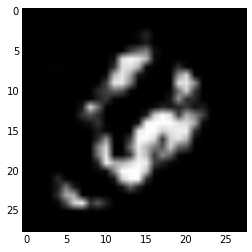

In [62]:
%matplotlib inline
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(100, nz)))
samples = np.asarray(_gen(sample_zmb))
plt.imshow(samples[0].reshape(28,28),'gray')

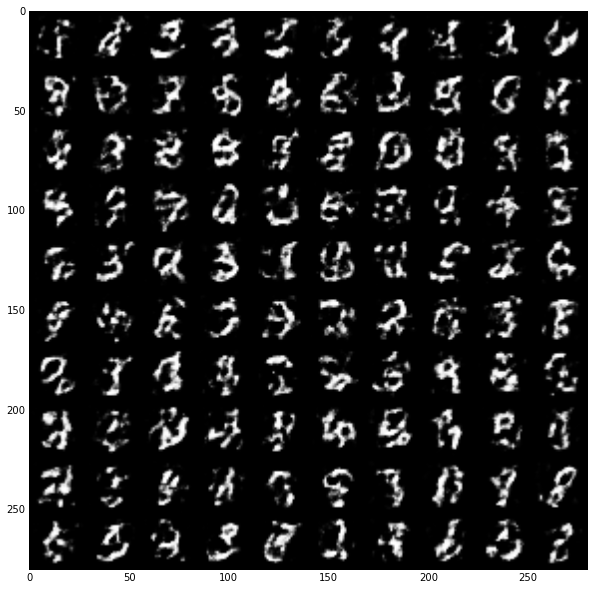

In [63]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

(array([ 663.,   24.,    7.,   11.,    5.,    6.,    3.,    8.,   11.,   46.]),
 array([  5.72710046e-10,   9.95050972e-02,   1.99010194e-01,
          2.98515290e-01,   3.98020387e-01,   4.97525484e-01,
          5.97030580e-01,   6.96535677e-01,   7.96040774e-01,
          8.95545870e-01,   9.95050967e-01]),
 <a list of 10 Patch objects>)

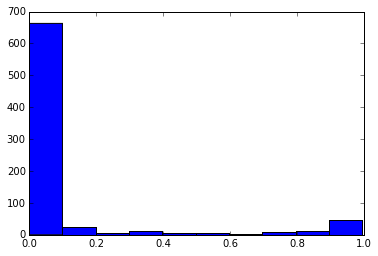

In [29]:
plt.hist(x_decoded.reshape(-1))